# Predicting Comment Score

In [1]:
import pandas as pd; import numpy as np; 
from scipy.sparse import csr_matrix
import nltk
import math; import time
# import enchant; english_dict = enchant.Dict("en_US")
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer
#from html.parser import HTMLParser
from sklearn.cross_validation import StratifiedKFold
from sklearn import linear_model
from sklearn import metrics
# from stemming.porter2 import stem
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = CountVectorizer(analyzer = "word", tokenizer = None, preprocessor = None, \
                             stop_words = None, max_features = 5000) 

import seaborn
import matplotlib
from matplotlib import pyplot as plt
#from matplotlib import pylab
%matplotlib inline
#%pylab inline
#pylab.rcParams['figure.figsize'] = (20, 5)

# Tsne
from sklearn import manifold

In [2]:
font = {'weight' : 'normal',
        'size'   : 22}

axes = {'titlesize'  : 22,
        'labelsize'  : 22}

legend = {'fontsize'  : 22}

figure = {'figsize'  : (10,5)}

matplotlib.rc('font', **font)
matplotlib.rc('axes', **axes)
matplotlib.rc('legend', **legend)
matplotlib.rc('figure', **figure)

## 1 Data

### 1.1 Import cleaned comments

In [3]:
dftrain = pd.read_csv("data/finalnostop.csv")

In [4]:
#dft_pic = dftrain[dftrain.subreddit=="pics"]
#dft_fun = dftrain[dftrain.subreddit=="funny"]
#dft_gof = dftrain[dftrain.subreddit=="GlobalOffensive"]
#dft_cje = dftrain[dftrain.subreddit=="circlejerk"]
#dft_all = [dft_pic, dft_nba, dft_wne, dft_fun, dft_aww, dft_gof, dft_cje]
dft_wne = dftrain[dftrain.subreddit=="worldnews"]
dft_aww = dftrain[dftrain.subreddit=="aww"]
dft_nba = dftrain[dftrain.subreddit=="nba"]

#dft_all_BOW = [dft_pic_BOW, dft_nba_BOW, dft_wne_BOW, dft_fun_BOW, dft_aww_BOW, dft_gof_BOW, dft_cje_BOW]
#dft_all_TFI = [dft_pic_TFI, dft_nba_TFI, dft_wne_TFI, dft_fun_TFI, dft_aww_TFI, dft_gof_TFI, dft_cje_TFI]

### 1.2 Extract features

In [5]:
dft = dftrain[dftrain.subreddit=="nba"]

In [6]:
# remove nans
def remove_nan(s):
    try:
        f = float(s)
        if math.isnan(f):
            return ""
    except:
        return s
sentences = []
for row in dft['body']:
    sentences.append(remove_nan(row)) 

In [7]:
print(remove_nan(str(float('nan'))))

In [8]:
dft.head()

,Unnamed: 0,Unnamed: 0.1,body,created_utc,score,link,subreddit
2,2,2,bruh,1456791980,1,http://reddit.com/r/nba/comments/48dhcw/c/d0iqq9r,nba
3,3,3,go http ftve akamaihd net hls live room k prog u,1459383579,1,http://reddit.com/r/nba/comments/4cnbpg/c/d1jt5ev,nba
5,5,5,kobe attempts year jason williams attempts yeesh,1459209968,1,http://reddit.com/r/nba/comments/4cbvvd/c/d1h18q2,nba
14,14,14,sound kinda mean man,1458173823,3,http://reddit.com/r/nba/comments/4aq1y4/c/d12o9bg,nba
15,15,15,hawks hitting stride gonna tough,1458605459,2,http://reddit.com/r/nba/comments/4beteo/c/d18j7fu,nba


## number of features to use???

What values to use??
occurred in too many documents (max_df): don't need to worry about this one!
occurred in too few documents (min_df): 
were cut off by feature selection (max_features)



In [9]:
# bag of words
vectorizer_count = CountVectorizer(analyzer = "word", tokenizer = None, preprocessor = None,
                                   stop_words = None, max_features = 5000) 
s_BOW = vectorizer_count.fit_transform(sentences)

In [10]:
# TF_IDF
vectorizer_tfid = TfidfVectorizer(analyzer = "word", tokenizer = None, preprocessor = None,
                                  stop_words = None, max_features = 5000) 
s_TFI = vectorizer_tfid.fit_transform(sentences)

# Visualize bag of words + tf_idf

In [11]:
a_BOW = s_BOW.toarray()
a_TFI = s_TFI.toarray()
print(a_BOW.shape)
print(a_TFI.shape)

(533931, 5000)
(533931, 5000)


To visualize, we need a smaller dataset than .5 million points. We can visualize what this data set looks like by taking a random sample of *200* points


http://scikit-learn.org/stable/auto_examples/manifold/plot_compare_methods.html#example-manifold-plot-compare-methods-py
http://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html

In [12]:
bow_small = a_BOW[np.random.randint(low=0,high=a_BOW.shape[0], size=5000), :]
tfi_small = a_TFI[np.random.randint(low=0,high=a_TFI.shape[0], size=5000), :]

# check to make sure (5000,5000)
print(bow_small.shape)

(5000, 5000)


t-SNE: 4.2e+02 sec


(-31.779484463617862,
 72.345407568485015,
 -22.241133477798542,
 39.308520225119267)

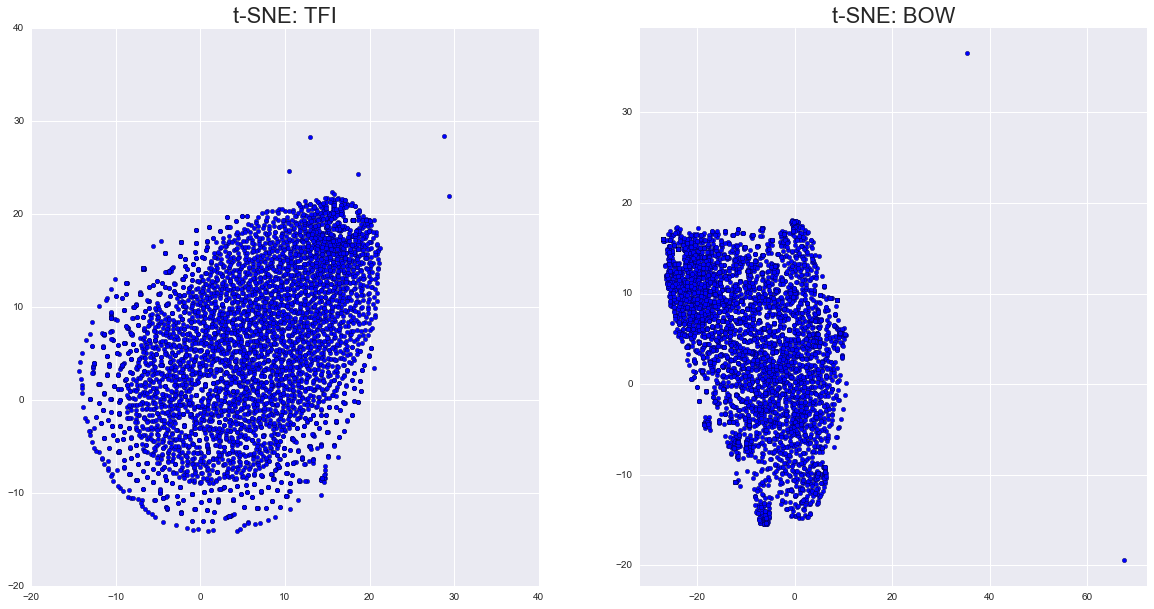

In [13]:
t0 = time.time()

# Perform TSNE
tsne = manifold.TSNE(n_components=2, init='pca', random_state=0)
Y_tfi = tsne.fit_transform(tfi_small)
Y_bow = tsne.fit_transform(bow_small)

# Print out timing
t1 = time.time()
print("t-SNE: %.2g sec" % (t1 - t0))

# Generate plots
f,ax = plt.subplots(1,2,figsize = (20,10))
ax[0].scatter(Y_tfi[:, 0], Y_tfi[:, 1])#, cmap=plt.cm.Spectral)
ax[0].set_title("t-SNE: TFI")
ax[1].scatter(Y_bow[:, 0], Y_bow[:, 1])#, cmap=plt.cm.Spectral)
ax[1].set_title("t-SNE: BOW")
plt.axis('tight')

In [ ]:
# Clean up
del a_BOW, a_TFI, bow_small, tfi_small

In [14]:
dft['score'].describe()

count    533931.000000
mean         10.576247
std          51.106897
min        -457.000000
25%           1.000000
50%           2.000000
75%           6.000000
max        4530.000000
Name: score, dtype: float64

In [15]:
dft['score'].mode()[0]

1

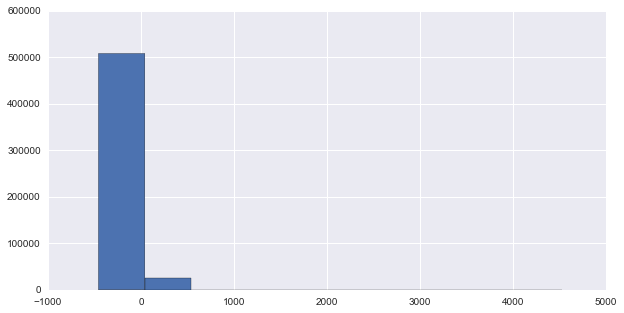

In [16]:
plt.hist(dft['score'])
plt.show()

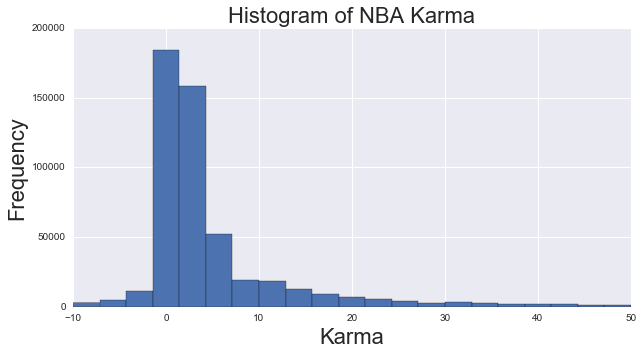

In [21]:
plt.hist(dft['score'],21,range=[-10, 50])
plt.title('Histogram of NBA Karma')
plt.xlabel('Karma')
plt.ylabel('Frequency')

# Clustering

## Regression

1. Remove points [0, 2]
3. Types of regressions

Ridge, Lasso, RF regression, SVR, Linear
CV

Expect RF to be best b/c euclidian distance assumption doesn't work

In [ ]:
# Remove points [0,2]
dft_small = dft[(dft['score']<0) | (dft['score']> 2)]

# Remove from bow and tfi as well
(ind,) = (np.where((dft['score']<0) | (dft['score']> 2)))
s_bow_small = s_BOW[ind,:]
#s_tfi_small = s_TFI[ind,:]

In [ ]:
print(type(s_bow_small), type(s_tfi_small))

In [ ]:
plt.hist(dft_small['score'],21,range=[-10, 20])
plt.title('Histogram of NBA Karma without [0,2]')
plt.xlabel('Karma')
plt.ylabel('Frequency')

## Regresssion

In [ ]:
ltype = 'BOW'

In [ ]:
scores = []
for row in dft['score']:
    scores.append((row))
    
scores = np.array(scores)

scores_small = scores[ind]

In [ ]:
print(scores_small.shape)

In [ ]:
k = 10
skf = StratifiedKFold(scores_small,n_folds=k, shuffle=True)

for train_i,test_i in skf:
    if ltype == 'BOW':
        X_val = s_bow_small[test_i,:]
        X = s_bow_small[train_i,:]
        
    Y_val = scores_small[test_i]
    Y = scores_small[train_i]
    break;

In [ ]:
from sklearn import linear_model
from sklearn import tree
from sklearn import svm
from sklearn import kernel_ridge
from sklearn import ensemble

In [ ]:
k = 10
skf = StratifiedKFold(Y,n_folds=k, shuffle=True)

In [ ]:
# Ridge, Lasso, RF regression, SVR, Linear
models = {#"Linear":linear_model.LinearRegression(normalize=True),
          #"Ridge": linear_model.Ridge(alpha = 0.5, fit_intercept=True, normalize=True),
          "Lasso": linear_model.Lasso(alpha=0.5, fit_intercept=True, normalize=True,
                                      selection='random',max_iter=1000), 
          #"SVR": svm.LinearSVR(),
          #"Gradesc": linear_model.SGDRegressor(penalty="l1", n_iter=15),
          #"DTree": tree.DecisionTreeRegressor(max_depth=6), 
          #"RF": ensemble.RandomForestRegressor(max_depth=6,n_estimators=16)
          #["B.Ridge ", linear_model.BayesianRidge()], \
          #["ABoost  ", ensemble.AdaBoostRegressor()], \
          }
mse = {}
runtimes = {}
for name in models.keys():
    mse[name] = np.empty((k,))
    runtimes[name] = np.empty((k,))

i = 0
alphas = np.linspace(0.05,1,k)
print('Trial\t\t'+'\t\t'.join(models.keys()))

for train_i, test_i in skf:

    print(i)
    
    if ltype == 'BOW':
        X_train, X_test = X[train_i,:],X[test_i,:]
        Y_train, Y_test = Y[train_i], Y[test_i]
        
    for name,model in models.iteritems():
        start_time = time.time()
        
        if name == 'Lasso':
            print('alpha = %1.3f' % alphas[i])
            model.set_params(alpha = alphas[i])
        fitted_model = model.fit(X_train, Y_train)
        Y_pred = fitted_model.predict(X_test)
        tim = time.time() - start_time
        runtimes[name][i] = tim
        mse[name][i] = metrics.mean_squared_error(Y_test, Y_pred)
    

    mse_print = 'MSE'
    time_print = 'Time'
    for name in models.keys():
        mse_print = mse_print + "\t\t" + format('%1.3f'%mse[name][i])
        time_print = time_print + "\t\t" + format('%1.3f'%runtimes[name][i])
    print(mse_print)
    print(time_print)
    i = i+1
    
    

In [ ]:
plt.plot(alphas,mse['Lasso'])

In [ ]:
f, ax = plt.subplots(1,2)
for name in models.keys():
    ax[0].plot(mse[name],label=name)
    ax[0].set_title("MSE of models")
    ax[0].set_xlabel("Trial")
    ax[0].set_ylabel('MSE')
    ax[0].legend()
    
    ax[1].plot(runtimes[name],label=name)
    ax[1].set_title("Runtimes of models")
    ax[1].set_xlabel("Trial")
    ax[1].set_ylabel('Time (s)')
    ax[1].legend()

# Classification

Note: we will set the following boundaries according to score:

Bad: <= 0

Neutral: 1

Good: 2, 3, 4

Very Good: >= 5

In [ ]:
# categorize each comment by score
def categorize(score):
    if score<=-5:
        return -2
    elif score>-5 and score < 0:
        return -1
    elif score >= 0 and score <= 2:
        return 0
    elif score >= 2 and score < 20:
        return 1
    elif score >= 20 and score <=100:
        return 2
    else:
        return 3

In [ ]:
ltype = 'BOW'

In [ ]:
labels = []
for row in dft['score']:
    labels.append(categorize(row))
labels = np.array(labels)
labels_small = labels[ind]

In [ ]:
k = 10
skf = StratifiedKFold(labels_small,n_folds=k, shuffle=True)

for train_i,test_i in skf:
    if ltype == 'BOW':
        X_val = s_bow_small[test_i,:]
        X = s_bow_small[train_i,:]
        
    Y_val = labels_small[test_i]
    Y = labels_small[train_i]
    break;

In [ ]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression

In [ ]:
nNeighbors = 10 #KNN
maxLearners = 100 #RF
maxDepth = 10 #RF
models = {"MNB": MultinomialNB(),
          #"KNN": KNeighborsClassifier(n_neighbors=nNeighbors), 
          #"LSV": LinearSVC(), 
          #"DFT": DecisionTreeClassifier(), 
          #"RFC": RandomForestClassifier(n_estimators=maxLearners, max_depth = maxDepth, warm_start = False), 
          #"LOR": LogisticRegression(),
          }

In [ ]:
k = 10
skf = StratifiedKFold(Y,n_folds=k, shuffle=True)

In [ ]:
accuracies = {}
f1scores = {}
precisions = {}
recalls = {}
runtimes = {}
for name in models.keys():
    accuracies[name] = np.empty((10,))
    f1scores[name] = np.empty((10,))
    precisions[name] = np.empty((10,))
    recalls[name] = np.empty((10,))
    runtimes[name] = np.empty((10,))
    
    
i = 0

for train_i, test_i in skf:
    if ltype == 'BOW':
        X_train, X_test = X[train_i,:],X[test_i,:]
        Y_train, Y_test = Y[train_i], Y[test_i]
        
    for name,model in models.iteritems():
        start_time = time.time()
        fitted_model = model.fit(X_train, Y_train)
        Y_pred = fitted_model.predict(X_test)
        tim = time.time() - start_time
        
        accuracies[name][i] = metrics.accuracy_score(Y_test, Y_pred)
        f1scores[name][i] = metrics.f1_score(Y_test, Y_pred)
        precisions[name][i] = metrics.precision_score(Y_test, Y_pred)
        recalls[name][i] = metrics.recall_score(Y_test, Y_pred)
        runtimes[name][i] = tim
    
    ac_print = str(i)
    f1scores_print = str(i)
    precisions_print = str(i)
    recalls_print = str(i)
    time_print = str(i)
    for name in models.keys():
        ac_print = ac_print + "\t\t" + format('%1.3f'%accuracies[name][i])
        f1scores_print = f1scores_print + "\t\t" + format('%1.3f'%f1scores[name][i])
        precisions_print = precisions_print + "\t\t" + format('%1.3f'%precisions[name][i])
        recalls_print = recalls_print + "\t\t" + format('%1.3f'%recalls[name][i])
        time_print = time_print + "\t\t" + format('%1.3f'%runtimes[name][i])
    print(mse_print)
    print(time_print)
    
    i = i+1


In [ ]:
for name in models.keys():
    print(name)
    #print(accuracies[name])
    #print(f1scores[name])
    #print(precisions[name])
    #print(recalls[name])
    #print(runtimes[name])
    print('AVG: Accuracy: %1.3f\tF1: %1.3f\tPrec: %1.3f\tRecall: %1.3f\tRuntime: %1.3f'%(
            np.mean(accuracies[name]), np.mean(f1scores[name]), np.mean(precisions[name]), np.mean(recalls[name]), np.mean(runtimes[name])))